In this demo we will analyze the mechanical vibration of a quadrotor during flight using publicly available logs.

We obtain the logs from review.px4.io, https://review.px4.io/plot_app?log=8aa57955-db73-46d5-8800-17903bbc3575

# Open the file

In [1]:
%pylab inline

import pyulog

with open('data/8aa57955-db73-46d5-8800-17903bbc3575.ulg', 'rb') as f:
    log = pyulog.ULog(f)

Populating the interactive namespace from numpy and matplotlib


# List the Data Topics

In [2]:
for data in log.data_list:
    print(data.name)

vehicle_local_position_setpoint
vehicle_magnetometer
vehicle_air_data
ekf2_timestamps
vehicle_status_flags
vehicle_status
vehicle_rates_setpoint
vehicle_local_position
vehicle_land_detected
vehicle_gps_position
vehicle_global_position
vehicle_attitude_setpoint
vehicle_attitude
telemetry_status
system_power
sensor_preflight
sensor_combined
safety
rate_ctrl_status
manual_control_setpoint
input_rc
home_position
estimator_status
ekf2_innovations
distance_sensor
cpuload
battery_status
actuator_outputs
actuator_outputs
actuator_controls_0


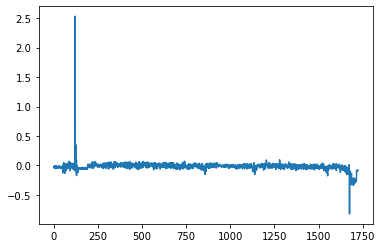

In [3]:
d = log.get_dataset('actuator_controls_0')
plt.plot(d.data['control[1]'])

In [4]:
import re
import sys

search_term = sys.argv[1]
f = sys.argv[2]

for k in log.initial_parameters.keys():
    if re.search('LOG', k):
        print(k)

SDLOG_DIRS_MAX
SDLOG_MODE
SDLOG_PROFILE
SDLOG_UTC_OFFSET
SDLOG_UUID
SYS_LOGGER


In [5]:
log.initial_parameters['SDLOG_PROFILE']

3

In [6]:
1/(np.diff(log.get_dataset('vehicle_attitude').data['timestamp'])/1e6)

array([31.09646122, 31.41887646, 31.18762475, ..., 31.23145632,
       34.59369703, 31.43467874])

In [7]:
for topic in log.data_list:
    print(topic.name)
    for k in log.get_dataset(topic.name).data.keys():
        print('\t', k)

vehicle_local_position_setpoint
	 timestamp
	 x
	 y
	 z
	 yaw
	 yawspeed
	 vx
	 vy
	 vz
	 acc_x
	 acc_y
	 acc_z
	 thrust[0]
	 thrust[1]
	 thrust[2]
vehicle_magnetometer
	 timestamp
	 magnetometer_ga[0]
	 magnetometer_ga[1]
	 magnetometer_ga[2]
vehicle_air_data
	 timestamp
	 baro_alt_meter
	 baro_temp_celcius
	 baro_pressure_pa
	 rho
ekf2_timestamps
	 timestamp
	 airspeed_timestamp_rel
	 distance_sensor_timestamp_rel
	 gps_timestamp_rel
	 optical_flow_timestamp_rel
	 vehicle_air_data_timestamp_rel
	 vehicle_magnetometer_timestamp_rel
	 vision_attitude_timestamp_rel
	 vision_position_timestamp_rel
vehicle_status_flags
	 timestamp
	 condition_calibration_enabled
	 condition_system_sensors_initialized
	 condition_system_hotplug_timeout
	 condition_system_returned_to_home
	 condition_auto_mission_available
	 condition_global_position_valid
	 condition_home_position_valid
	 condition_local_position_valid
	 condition_local_velocity_valid
	 condition_local_altitude_valid
	 condition_power_inpu

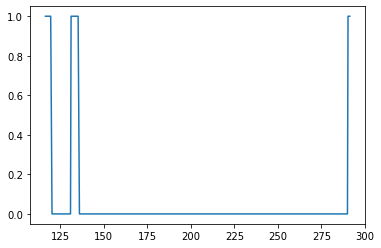

In [8]:
ld = log.get_dataset('vehicle_land_detected').data
plt.plot(ld['timestamp']/1e6, ld['landed'])

In [9]:
log.get_dataset('vehicle_status').data.keys()

dict_keys(['timestamp', 'onboard_control_sensors_present', 'onboard_control_sensors_enabled', 'onboard_control_sensors_health', 'nav_state', 'arming_state', 'hil_state', 'failsafe', 'system_type', 'system_id', 'component_id', 'is_rotary_wing', 'is_vtol', 'vtol_fw_permanent_stab', 'in_transition_mode', 'in_transition_to_fw', 'rc_signal_lost', 'rc_input_mode', 'data_link_lost', 'high_latency_data_link_active', 'data_link_lost_counter', 'engine_failure', 'mission_failure'])

# Plot the raw x acceleration, about the aircraft roll axis

In [10]:
sensor = log.get_dataset('sensor_combined')

Text(0, 0.5, 'accel m/s^2')

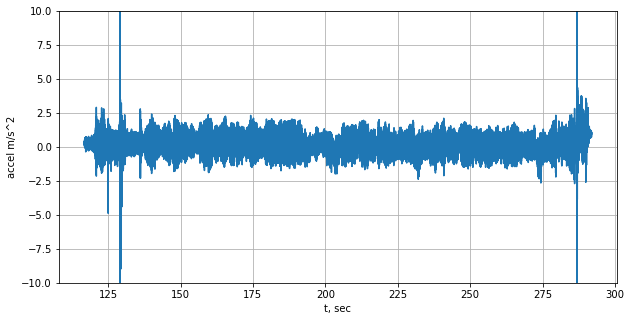

In [11]:
accx = sensor.data['accelerometer_m_s2[0]']
t = sensor.data['timestamp']/1.0e6
plt.figure(figsize=(10, 5))
plt.plot(t, accx)
plt.gca().set_ylim(-10, 10)
plt.grid()
plt.xlabel('t, sec')
plt.ylabel('accel m/s^2')

## Compute the Sample Time

(0.004021126940387619, 248.68650376493818)

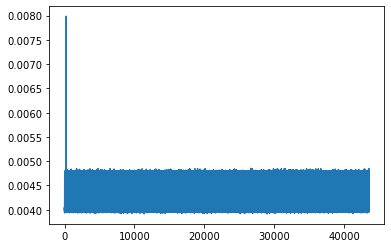

In [12]:
plt.plot(np.diff(t))
Ts = np.mean(np.diff(t))
Ts, 1/Ts

## Find the Vibrational Frequencies

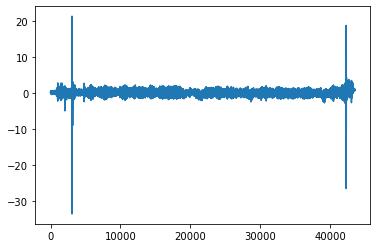

In [13]:
plot(accx)

(0.01587309348631112+0.06375614616420029j)

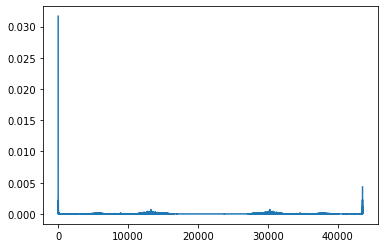

In [14]:
ak = fft.ifft(accx)
plot(abs(ak)**2)
ak[1]

In [15]:
def power_spectrum(t, y, dB=False):
    n = len(y)
    ak = np.fft.ifft(y)
    n_half = int(np.ceil(n/2))
    freq = np.fft.fftfreq(n, Ts)
    
    if dB:
        amp_dB = 20*np.log10(np.abs(ak[:n_half]))
        plt.plot(freq[:n_half], amp_dB)
        plt.ylabel('dB')
    else:
        amp_power = np.abs(np.abs(ak[:n_half]))**2
        plt.plot(freq[:n_half], amp_power)
        plt.ylabel('power')
    
    plt.xlabel('freq, Hz')
    plt.title('power spectrum')
    plt.grid()

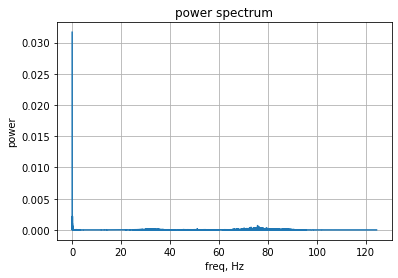

In [16]:
power_spectrum(t, accx)

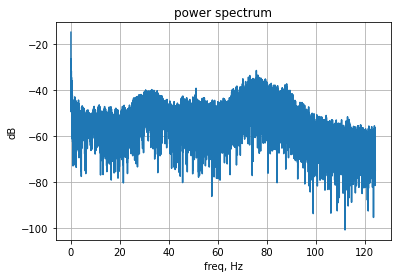

In [17]:
power_spectrum(t, accx, dB=True)

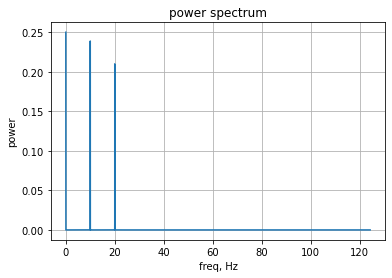

In [18]:
test_sig = 0.5 + np.sin(2*np.pi*20*t) + np.sin(2*np.pi*10*t)
power_spectrum(t, test_sig)

In [19]:
accx

array([0.3286899 , 0.30519062, 0.10277385, ..., 0.9753689 , 1.071429  ,
       0.94860506], dtype=float32)

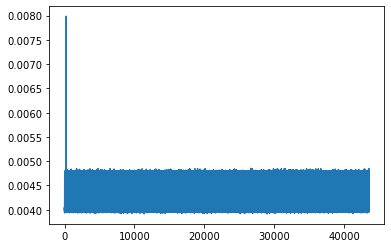

In [22]:
plt.plot(np.diff(t))

In [23]:
np.mean(np.diff(t))

0.004021126940387619

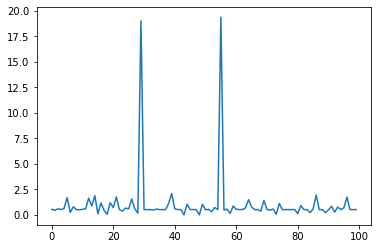

In [32]:
dt = np.mean(np.diff(t))
rel_time_diff = abs(np.diff(t) - dt)/dt
plot(100*rel_time_diff[:100])

In [33]:
dt

0.004021126940387619

In [36]:
tau = t[-1] - t[0]  # last t - first t
nu = len(t)
dt2 = tau/(nu - 1)
dt2

0.004021126940387619

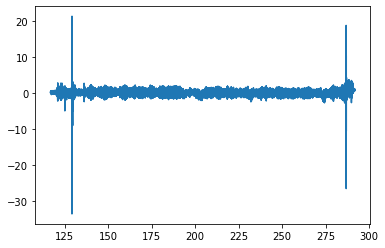

In [37]:
plot(t, accx)

In [38]:
tau

175.11203600000005

In [42]:
freq = fftfreq(nu, dt)